In [1]:
# import package

# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import StepLR

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import os

# display images
from torchvision import utils
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

# utils
import numpy as np
import time
import copy

In [2]:
image_dir = './categories_v2'
train_path = './categories_v2/train'
valid_path = './categories_v2/validation'
test_path = './categories_v2/test'
print(os.listdir(test_path))
num_classes = len(os.listdir(test_path))

FileNotFoundError: [Errno 2] No such file or directory: './categories_v2/test'

In [ ]:
class DatasetProcessing(Dataset):
    def __init__(self, data_path, img_path, img_filename, label_filename, transform=None):
        self.img_path = os.path.join(data_path, img_path)
        self.transform = transform
        # reading img file from file
        img_filepath = os.path.join(data_path, img_filename)
        fp = open(img_filepath, 'r')
        self.img_filename = [x.strip() for x in fp]
        fp.close()
        # reading labels from file
        label_filepath = os.path.join(data_path, label_filename)
        labels = np.loadtxt(label_filepath, dtype=np.int64)
        self.label = labels

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_path, self.img_filename[index]))
        img = img.convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        label = torch.from_numpy(self.label[index])
        return img, label
    def __len__(self):
        return len(self.img_filename)

In [ ]:
DATA_PATH = 'categories_v2'
VALID_DATA = 'valid_folder'
VALID_IMG_FILE = 'valid_img.txt'
VALID_LABEL_FILE = 'valid_label.txt'
TRAIN_DATA = 'train_folder'
TRAIN_IMG_FILE = 'train_img.txt'
TRAIN_LABEL_FILE = 'train_label.txt'

ResNet50 모델의 형태를 미리 선언

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)

print(device)

cuda


In [ ]:
transform_test = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
validset = datasets.ImageFolder(root=valid_path, transform=transform_test)
dset_valid = DatasetProcessing(
    DATA_PATH, VALID_DATA, VALID_IMG_FILE, VALID_LABEL_FILE, transform_test)

dset_train = DatasetProcessing(
    DATA_PATH, TRAIN_DATA, TRAIN_IMG_FILE, TRAIN_LABEL_FILE, transform_test)

In [ ]:
# import resnet
from torchvision import models
import torch.nn as nn
import torch.optim as optim

model = models.resnet50(pretrained = True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

In [ ]:
testloader = DataLoader(dset_valid, batch_size=16,
                            shuffle=False)
trainloader = DataLoader(dset_train, batch_size=16,
                            shuffle=False)

In [ ]:
resnet50 = torch.load('resnet50_categories_v2_30.pt')

test data들을 ResNet 모델에 적용시키는 함수

In [ ]:
from matplotlib import pyplot as plt
import sklearn
from sklearn import manifold
from typing import Text
from itertools import cycle
import PIL
import numpy as np

In [ ]:
def average_precision(output, target):
    epsilon = 1e-8

    # sort examples
    indices = output.argsort()[::-1]
    # Computes prec@i
    total_count_ = np.cumsum(np.ones((len(output), 1)))

    target_ = target[indices]
    ind = target_ == 1
    pos_count_ = np.cumsum(ind)
    total = pos_count_[-1]
    pos_count_[np.logical_not(ind)] = 0
    pp = pos_count_ / total_count_
    precision_at_i_ = np.sum(pp)
    precision_at_i = precision_at_i_ / (total + epsilon)

    return precision_at_i

def mAP(targs, preds):
    """Returns the model's average precision for each class
    Return:
        ap (FloatTensor): 1xK tensor, with avg precision for each class k
    """

    if np.size(preds) == 0:
        return 0
    ap = np.zeros((preds.shape[1]))
    # compute average precision for each class
    for k in range(preds.shape[1]):
        # sort scores
        scores = preds[:, k]
        targets = targs[:, k]
        # compute average precision
        ap[k] = average_precision(scores, targets)
    return 100 * ap.mean()


In [ ]:
def get_representation(model, iterator):
  
  model.eval()
  Sig = torch.nn.Sigmoid()
  preds_regular = []
  targets = []
  for i, data in enumerate(iterator, 0): # batch 루프
      # get the inputs
      test_inputs, labels = data # input data, label 분리
      test_inputs = test_inputs.to(device)
      labels = labels.to(device)

      with torch.no_grad():
        with torch.autocast('cuda'):
          output_regular = Sig(model(test_inputs).float()).cpu()
          print(output_regular)
                  
      # for mAP calculation
      preds_regular.append(output_regular.cpu().detach())
      targets.append(labels.cpu().detach())
  mAP_score_regular = mAP(torch.cat(targets).numpy(), torch.cat(preds_regular).numpy())
  return preds_regular, targets, mAP_score_regular

In [ ]:
testoutputs, testlabels, testmAP = get_representation(resnet50, testloader)
trainoutputs, trainlabels, trainmAP = get_representation(resnet50, trainloader)

In [ ]:
category = [
    'glitter','french','gradation','parts','marble','pattern','resin',
    'check','powder','onetone','cheek','syrup','character'
]

In [ ]:
testlabels = torch.cat(testlabels, dim=0)
testoutputs = torch.cat(testoutputs, dim=0)
trainlabels = torch.cat(trainlabels, dim=0)
trainoutputs = torch.cat(trainoutputs, dim=0)

In [ ]:
testtargets = np.array(testlabels)
testpreds = np.array(testoutputs)
testoutputs = np.array(testoutputs)
traintargets = np.array(trainlabels)
trainpreds = np.array(trainoutputs)
trainoutputs = np.array(trainoutputs)

In [ ]:
testpreds = (testpreds > 0.5)
testoutputs = (testoutputs > 0.5)
testoutputs = np.where(testoutputs == True, 1, 0)
trainpreds = (trainpreds > 0.5)
trainoutputs = (trainoutputs > 0.5)
trainoutputs = np.where(trainoutputs == True, 1, 0)

In [ ]:
import sklearn
from sklearn.metrics import classification_report , average_precision_score
import sklearn.metrics as metrics
import itertools

print('mAP')
print(testmAP)
print('classification report')
print(classification_report(testtargets, testpreds))

score = metrics.precision_score(testtargets,testpreds, average='weighted')
print('precision score: {:.2f}'.format(score))
score = metrics.recall_score(testtargets, testpreds, average='weighted')
print('recall score: {:.2f}'.format(score))
score = metrics.f1_score(testtargets, testpreds, average='weighted')
print('f1 score: {:.2f}'.format(score))
score = metrics.accuracy_score(testtargets, testpreds)
print('accuracy score: {:.2f}'.format(score))
print('mAP score: {:.2f}'.format(testmAP))

mAP
82.2106306980915
classification report
              precision    recall  f1-score   support

           0       0.78      0.98      0.87        94
           1       0.64      0.83      0.72       115
           2       0.40      0.83      0.54        88
           3       0.56      0.90      0.69       110
           4       0.58      0.81      0.68       113
           5       0.84      0.98      0.91       132
           6       0.48      0.82      0.61       117
           7       0.72      0.96      0.82        67
           8       0.51      0.82      0.63        89
           9       0.57      0.94      0.71       188
          10       0.63      0.85      0.73       112
          11       0.42      0.88      0.57       152
          12       0.74      0.86      0.79       132

   micro avg       0.58      0.88      0.70      1509
   macro avg       0.61      0.88      0.71      1509
weighted avg       0.60      0.88      0.71      1509
 samples avg       0.68      0.88    

/home/jrin330/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import itertools
import warnings
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def confusion_matrix(y_test, y_pred):
    if len(y_test.shape) != 2:
        raise IOError('y_test must be a 2D array (Matrix)')
    elif len(y_pred.shape) != 2:
        raise IOError('y_pred must be a 2D array (Matrix)')

    cm = np.zeros((y_test.shape[1], y_test.shape[1]))

    for obs in range(0, len(y_pred[:, 0])):
        j = y_pred[obs, :].argmax()
        i = y_test[obs, :].argmax()
        cm[i, j] += 1
                
    accuracy = 0.0
    for i in range(0, cm.shape[1]):
        accuracy += cm[i, i]
    accuracy /= len(y_test.argmax(axis=1))
    print ("Accuracy on the test-set: " + str(accuracy))

    return cm

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.ion()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        if np.isnan(cm).any():
            np.nan_to_num(cm, copy=False)
            
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(i, j, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')
    plt.ioff()

In [ ]:
def draw_cm(y_test, y_pred, classes, normalize=False):
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, classes, normalize)

    return cm

Accuracy on the test-set: 0.6770557029177718


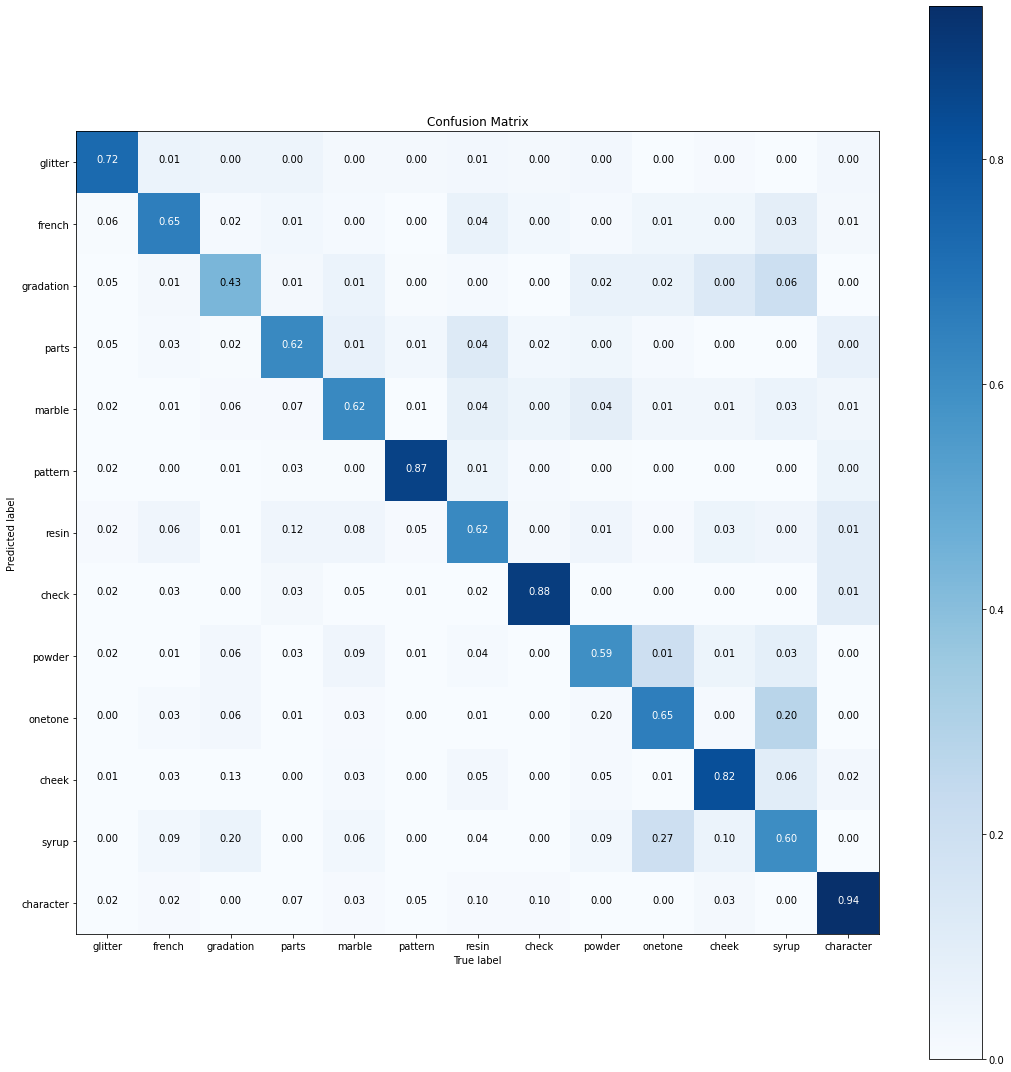

In [ ]:
conf_mat = draw_cm(testoutputs, testlabels, category, normalize=True)

In [ ]:
print('mAP')
print(trainmAP)
print('classification report')
print(classification_report(traintargets, trainpreds))
score = metrics.precision_score(traintargets,trainpreds, average='weighted')
print('precision score: {:.2f}'.format(score))
score = metrics.recall_score(traintargets, trainpreds, average='weighted')
print('recall score: {:.2f}'.format(score))
score = metrics.f1_score(traintargets, trainpreds, average='weighted')
print('f1 score: {:.2f}'.format(score))
score = metrics.accuracy_score(traintargets, trainpreds)
print('accuracy score: {:.2f}'.format(score))
print('mAP score: {:.2f}'.format(trainmAP))

mAP
98.4221762041588
classification report
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       767
           1       0.83      1.00      0.91       913
           2       0.56      0.98      0.71       705
           3       0.75      1.00      0.85       862
           4       0.80      1.00      0.89       926
           5       0.96      1.00      0.98      1062
           6       0.76      0.99      0.86       953
           7       0.89      0.99      0.94       530
           8       0.67      0.98      0.80       712
           9       0.63      1.00      0.77      1519
          10       0.80      1.00      0.89       885
          11       0.52      0.99      0.68      1212
          12       0.89      1.00      0.94      1029

   micro avg       0.73      0.99      0.84     12075
   macro avg       0.77      0.99      0.86     12075
weighted avg       0.76      0.99      0.85     12075
 samples avg       0.84      0.99    

/home/jrin330/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy on the test-set: 0.840451316339323


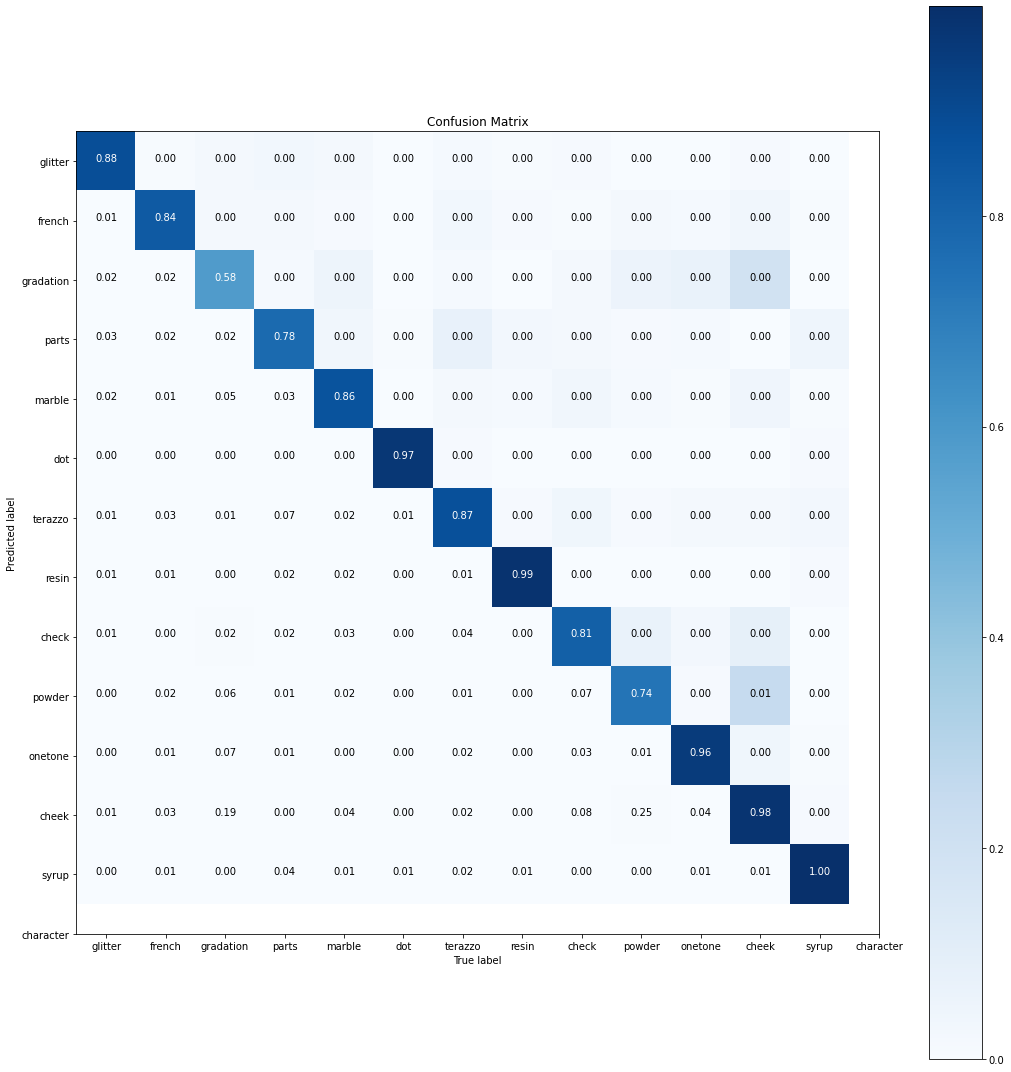

In [ ]:
conf_mat = draw_cm(trainoutputs, trainlabels,category,normalize=True)